This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,

In [2]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.gridspec as gridspec

import component_separation.MSC.MSC.pospace as ps

from lerepi.config.cmbs4.data import data_08d as sims_if
sims  = sims_if.ILC_May2022('00')

simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

MSC: reverting to standard healpy


In [3]:
def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

# Tiniti

In [3]:
oldtiniti = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/OBD_matrix/tniti.npy')
newtiniti = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test2/OBD_matrix/tniti.npy')
# oldtiniti = np.load('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/tniti.npy')

(5000.0, 6000.0)

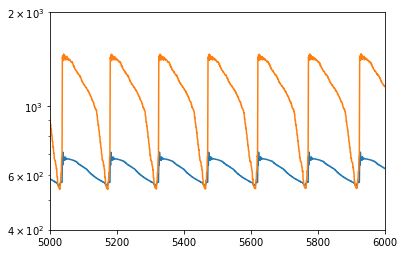

In [18]:
plt.plot(np.diag(newtiniti))
plt.plot(np.diag(oldtiniti)*3)
plt.yscale('log')
plt.ylim(4e2,2e3)
plt.xlim(5000, 6000)

(1.0, 3.0)

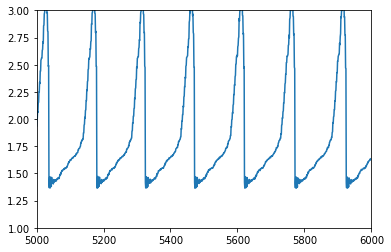

In [15]:
plt.plot(np.diag(newtiniti)/np.diag(oldtiniti))
plt.xlim(5000, 6000)
plt.ylim(1,3)
# np.sum(newtiniti)-np.sum(oldtiniti)

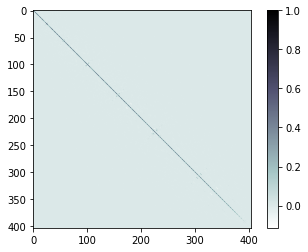

In [13]:
plt.imshow(newtiniti[::100,::100]/np.max(newtiniti[::100,::100]), cmap='bone_r')
plt.colorbar()

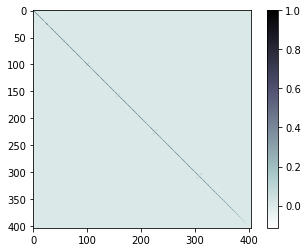

In [14]:
plt.imshow(oldtiniti[::100,::100]/np.max(oldtiniti[::100,::100]), cmap='bone_r')
plt.colorbar()

# OBD

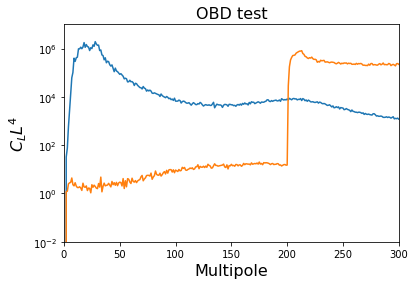

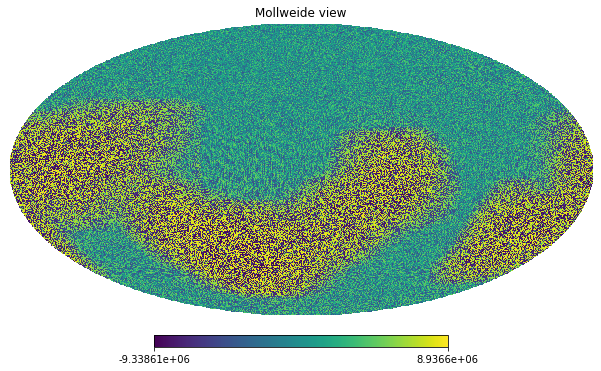

In [5]:
elm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_rinf_tol4/ivfs/sim_0000_elm.fits')
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_rinf_tol4/ivfs/sim_0000_blm.fits')
plt.plot(hp.alm2cl(elm), label='ClEE')
plt.plot(hp.alm2cl(blm), label='ClBB')

plt.title('OBD test', fontsize=16)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)

plt.yscale('log')
plt.ylim(1e-2,1e7)
plt.xlim(0,300)
plt.show()
bmap = hp.alm2map(blm, nside=2048)
hp.mollview(bmap, norm='hist')

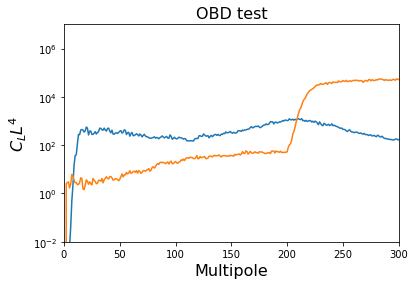

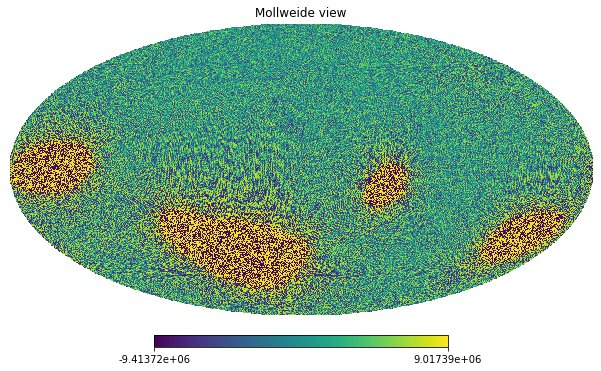

In [105]:
elm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/sim_0000_elm.fits')
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/sim_0000_blm.fits')
plt.plot(hp.alm2cl(elm), label='ClEE')
plt.plot(hp.alm2cl(blm), label='ClBB')

plt.title('OBD test', fontsize=16)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)

plt.yscale('log')
plt.ylim(1e-2,1e7)
plt.xlim(0,300)
plt.show()
bmap = hp.alm2map(blm, nside=2048)
hp.mollview(bmap, norm='hist')

# qlm

In [20]:
qlm1 = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_p_p_0000.fits')
qlm2 = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_p_p_0001.fits')
qmap1 = hp.alm2map(bandpass_alms(qlm1,30,200), nside=2048)
qmap2 = hp.alm2map(bandpass_alms(qlm2,30,200), nside=2048)

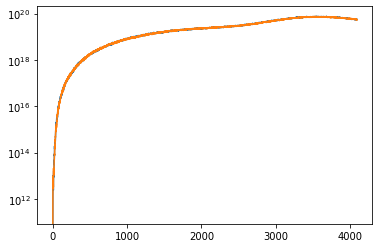

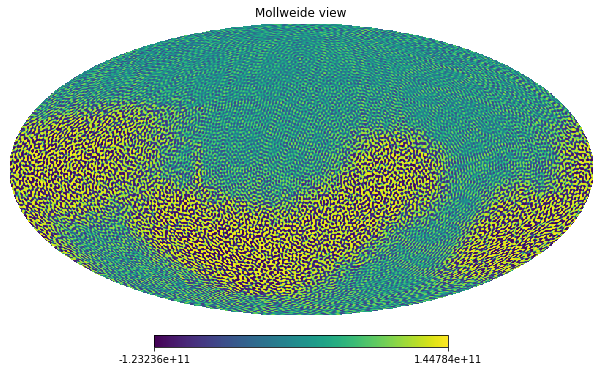

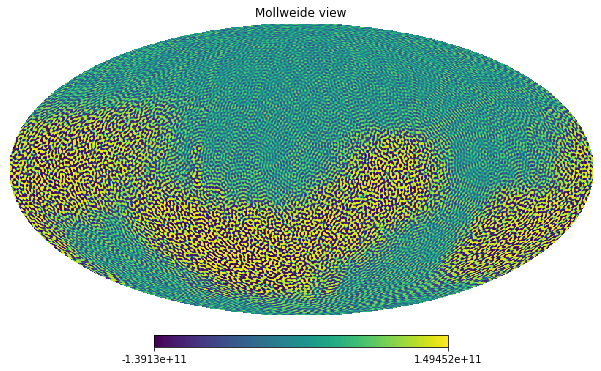

In [21]:
plt.plot(hp.alm2cl(qlm1), label='qlm')
plt.plot(hp.alm2cl(qlm2), label='qlm')
plt.yscale('log')
# plt.ylim(1e2,1e7)
# plt.xlim(0,300)
plt.show()

hp.mollview(qmap1, norm='hist')
hp.mollview(qmap2, norm='hist')

# Meanfield

In [42]:
mf1 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim0000/mf.npy')
mf2 = np.load('/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/p_p_sim0000mf07/mf.npy')
mf1_map = hp.alm2map(mf1, nside=2048)
mf1_map_bp = hp.alm2map(bandpass_alms(mf1,30,200), nside=2048)
mf2_map = hp.alm2map(mf2, nside=2048)
mf2_map_bp = hp.alm2map(bandpass_alms(mf2,30,200), nside=2048)

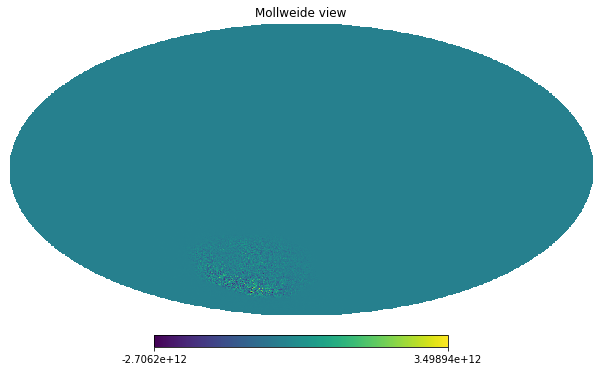

In [44]:
hp.mollview(mf1_map-mf2_map)

In [52]:
mf_cross = hp.alm2cl(mf1, alms2=mf2)

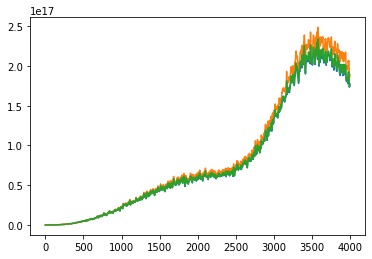

In [55]:
plt.plot(hp.alm2cl(mf1))
plt.plot(hp.alm2cl(mf2))
plt.plot(mf_cross)

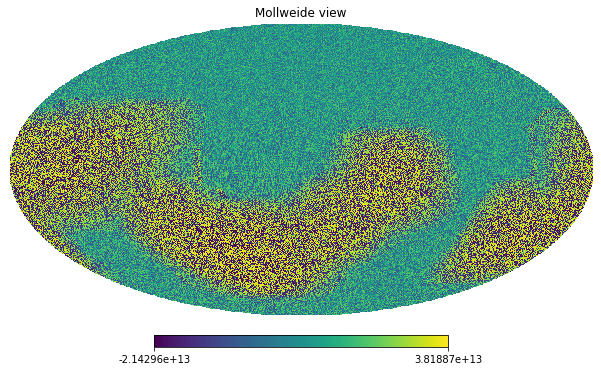

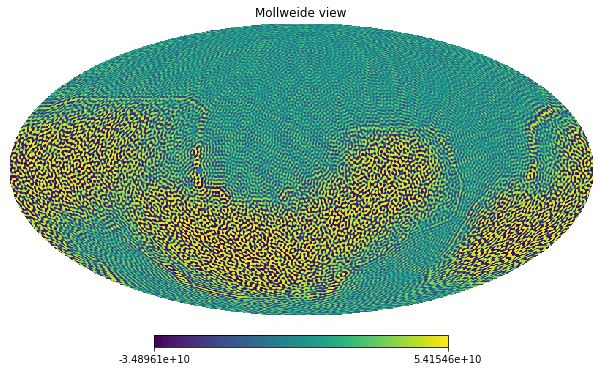

In [13]:
hp.mollview(mf_map, norm='hist')#, norm='hist')
hp.mollview(mf_map_bp, norm='hist')#, norm='hist')
hp.projscatter(theta=90.224915654872930/180*np.pi, phi=63.022222222222219/180*np.pi, lonlat=False)

In [45]:
msk_r5 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/fmask.fits.gz')

In [48]:
from MSC import pospace as ps
mf_cl = ps.map2cl(mf_map, msk_r5, 2048, 4096)

In [53]:
mf_cl_hp = hp.anafast(mf_map, lmax=2048)

(10000000000.0, 1e+18)

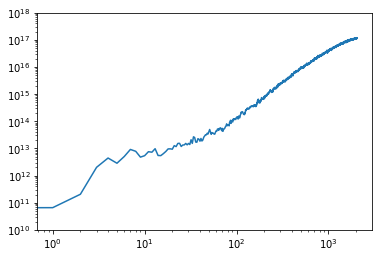

In [57]:
plt.plot(mf_cl_hp)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e10,1e18)

# Plm

*** Could only build up to itr number 2


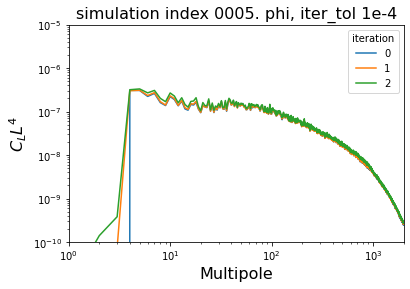

In [40]:
from lenscarf.iterators.statics import rec as rec
# from itercurv.iterators.statics import rec as 
simidx = '0005'
libdir_iterator = '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_rinf_tol4/p_p_sim{}/'.format(simidx)
# libdir_iterator = '/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/zb_terator_p_p_0000_nofg_OBD_solcond_3apr20/'
plms = rec.load_plms(libdir_iterator, range(12))
for n in range(len(plms)):
    pcl = hp.alm2cl(plms[n])
    plt.plot(pcl*np.arange(len(pcl))**4, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(title='iteration')
plt.xlim(1e0,2e3)
plt.ylim(1e-10,1e-5)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)
plt.title('simulation index {}. phi, iter_tol 1e-4'.format(simidx), fontsize=16)
plm_sim = plms[0]

In [38]:
pmaps = np.array([hp.alm2map(plm, nside=2048) for plm in plms])

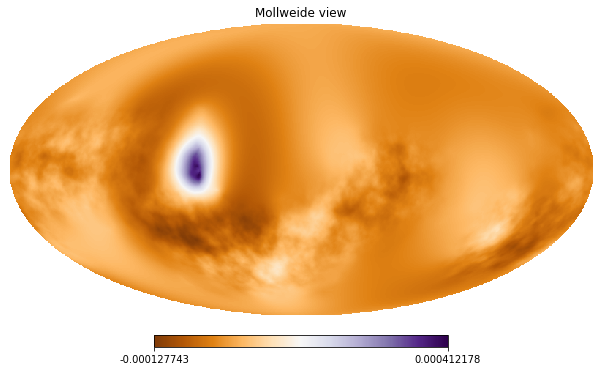

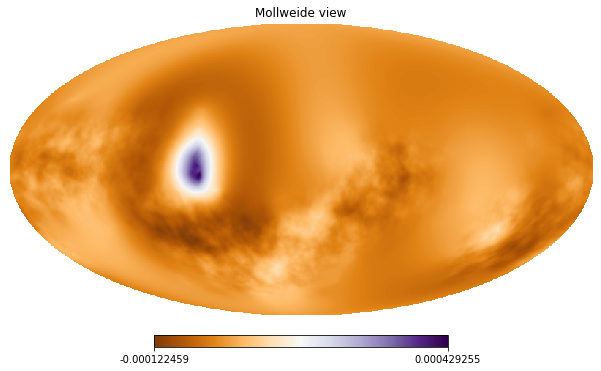

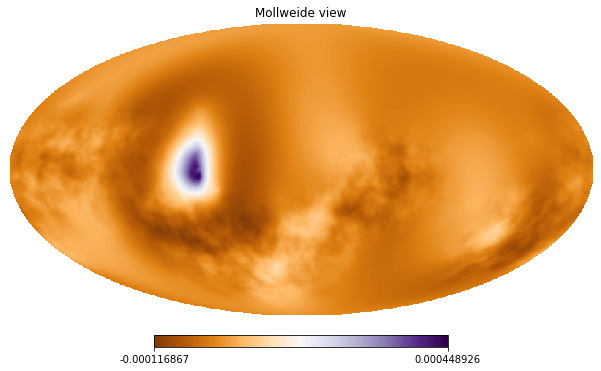

In [39]:
for pmap in pmaps:
    hp.mollview(pmap, cmap='PuOr')

In [182]:
# PICO
iteration = [0]
plm_sim = rec.load_plms('/global/cscratch1/sd/sebibel/lenscarfrecs/PICO_M21_N2048_smoothnoise/p_p_sim%04dhbumpnoMF/'%simidx, iteration)[0]

# Delensing efficiency

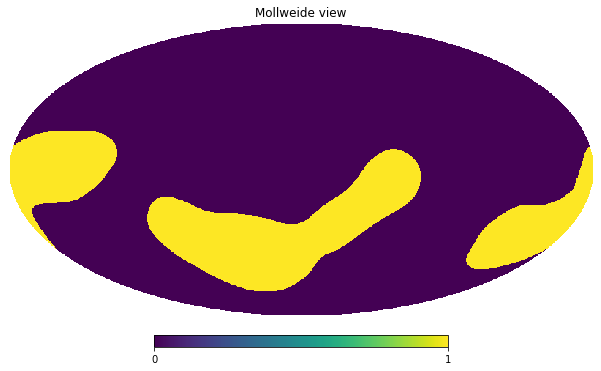

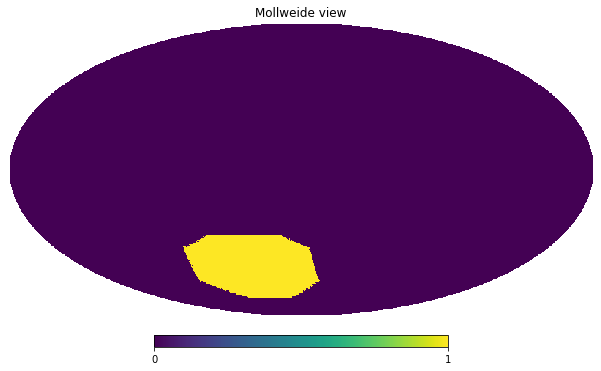

In [193]:
from plancklens.sims import planck2018_sims
from MSC import pospace as ps

msk_08d = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r10/ivfs/fmask.fits.gz')
hp.mollview(msk_08d)
msk_08b = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/cinvpOBD/fmask.fits.gz')
hp.mollview(msk_08b)

In [175]:
msk_08b_dg = hp.ud_grade(msk_08b, nside_out=1024)
msk_08b_dg.shape

(12582912,)

In [197]:
msk = msk_08d # np.where(msk_08d,1,1)
simidx = 1
lmax_transf = 2500
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

plm_fid = utils.alm_copy(planck2018_sims.cmb_unl_ffp10.get_sim_plm(simidx), lmax=lmax_transf)
pmap_fid = hp.alm2map(plm_fid, nside=2048)

plm_sim = hp.almxfl(plm_sim, 1/transf)
pmap_sim = hp.alm2map(plm_sim, nside=2048)

# plm_sim = hp.map2alm(pmap_sim, lmax=2500)
# plm_sim = hp.almxfl(plms[0], 1/transf)

cplm_cross = ps.map2cl(pmap_sim, msk, 1024, 2048, tmap2=pmap_fid)
# cplm_cross = hp.alm2cl(plm_sim, plm_fid)
cplm_sim = ps.map2cl(pmap_sim, msk, 1024, 2048)
cplm_fid = ps.map2cl(pmap_fid, msk, 1024, 2048)

(0.0, 1.0)

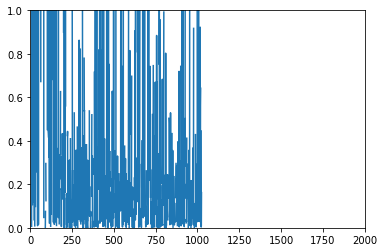

In [199]:
plt.plot((cplm_cross/np.sqrt(cplm_sim*cplm_fid))**2)
plt.xlim(0,2000)
plt.ylim(0,1)
# plt.xscale('log')
# plt.yscale('log')

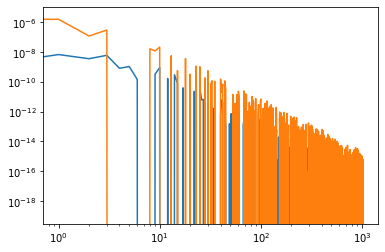

In [192]:
plt.plot(cplm_sim)
plt.plot(cplm_fid)
plt.xscale('log')
plt.yscale('log')

# Response

In [96]:
from plancklens import utils, qresp
from healpy import gauss_beam
from os.path import join as opj
import plancklens
from lenscarf.utils import cli

lmax_ivf = 4000
lmin_tlm = 30
lmin_elm = 30
lmin_blm = 30
beam = 2.3
lmax_qlm = 4000
nlev_t, nlev_p = (0.59/np.sqrt(2), 0.59)
k='p_p'

cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))

transf_tlm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_tlm)
transf_elm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_elm)
transf_blm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_blm)

# Isotropic approximation to the filtering (used eg for response calculations)
ftl =  cli(cls_len['tt'][:lmax_ivf + 1] + (nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2)) * (transf_tlm > 0)
fel =  cli(cls_len['ee'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_elm > 0)
fbl =  cli(cls_len['bb'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_blm ** 2)) * (transf_blm > 0)

R_59 = qresp.get_response(k, lmax_ivf, 'p', cls_len, cls_len, {'e': fel, 'b': fbl, 't':ftl}, lmax_qlm=lmax_qlm)[0]

In [93]:
fg='00'
tempmfvar = '/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_%s_lmax4000/'%(fg)
respG_grad, respC_grad = np.loadtxt(tempmfvar + '/resp_grad_%s.dat' % k).transpose()

transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

ftl_stp_nocut = utils.cli(cls_len['tt'][:lmax_ivf_qe + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf[:lmax_ivf_qe+1]  ** 2)
fel_stp_nocut = utils.cli(cls_len['ee'][:lmax_ivf_qe + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf[:lmax_ivf_qe+1]  ** 2)
fbl_stp_nocut = utils.cli(cls_len['bb'][:lmax_ivf_qe + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf[:lmax_ivf_qe+1]  ** 2)

filt_t = np.ones(lmax_ivf_qe + 1, dtype=float); filt_t[:lmin_ivf_qe] = 0.
filt_e = np.ones(lmax_ivf_qe + 1, dtype=float); filt_e[:lmin_ivf_qe] = 0.
filt_b = np.ones(lmax_ivf_qe + 1, dtype=float); filt_b[:lmin_ivf_qe] = 0.


ftl_stp = ftl_stp_nocut * filt_t
fel_stp = fel_stp_nocut * filt_e
fbl_stp = fbl_stp_nocut * filt_b

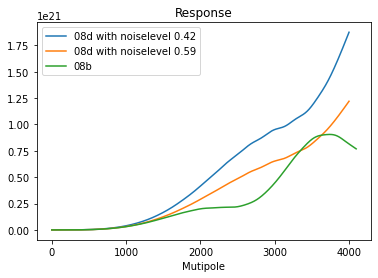

In [97]:
plt.plot(R, label='08d with noiselevel 0.42')
plt.plot(R_59, label='08d with noiselevel 0.59')
plt.plot(respG_grad, label='08b')
plt.title('Response')
plt.xlabel('Mutipole')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1,100)
# plt.ylim(1e6,1e14)

In [88]:
# pmaps_bp = np.array([hp.alm2map(bandpass_alms(p,30,1000), nside=2048) for p in plms])
pmaps = np.array([hp.alm2map(p, nside=2048) for p in plms])

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


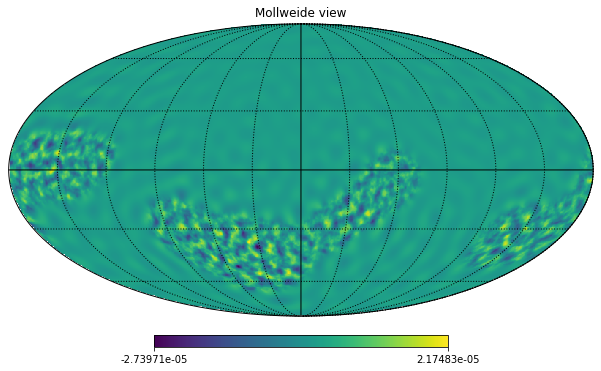

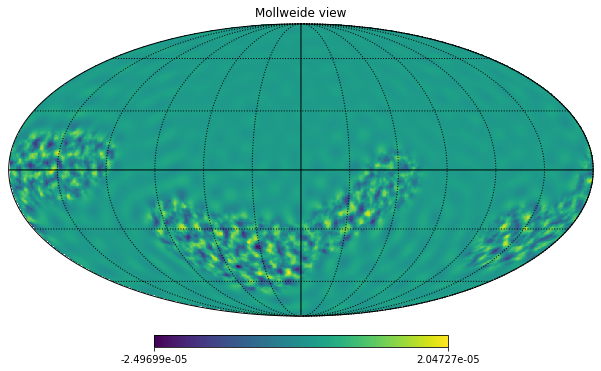

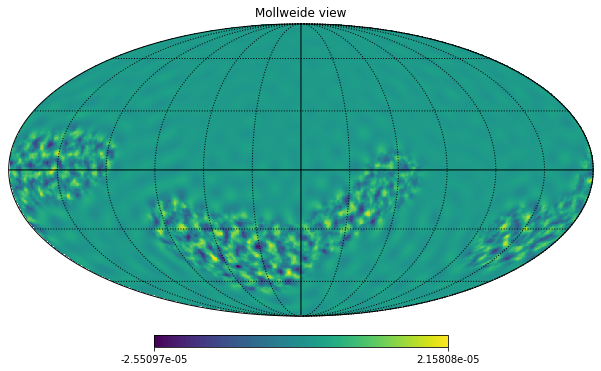

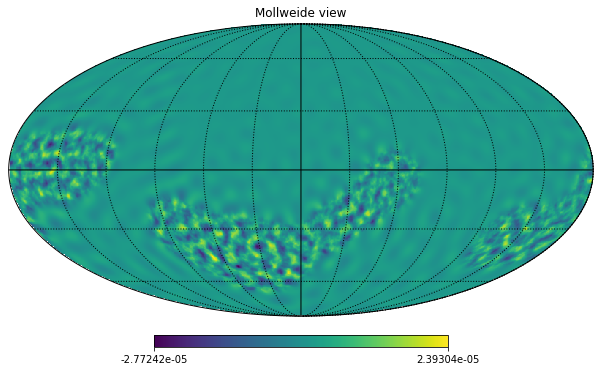

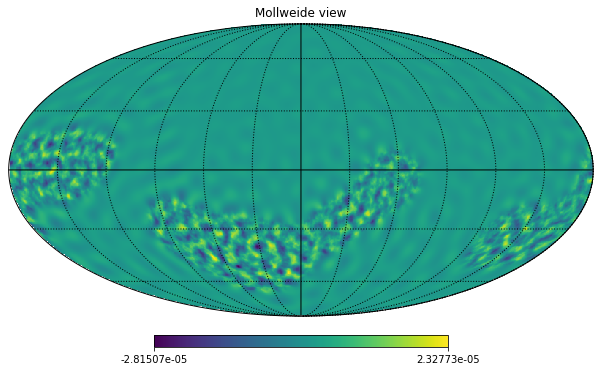

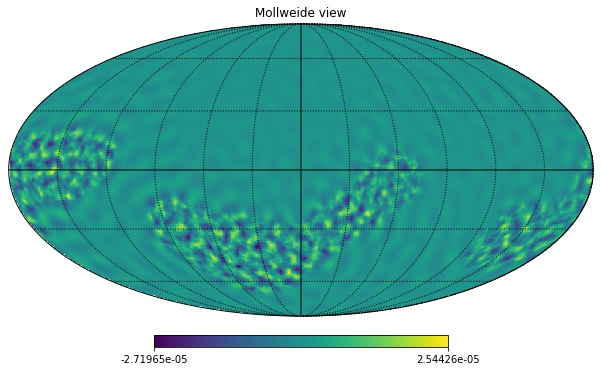

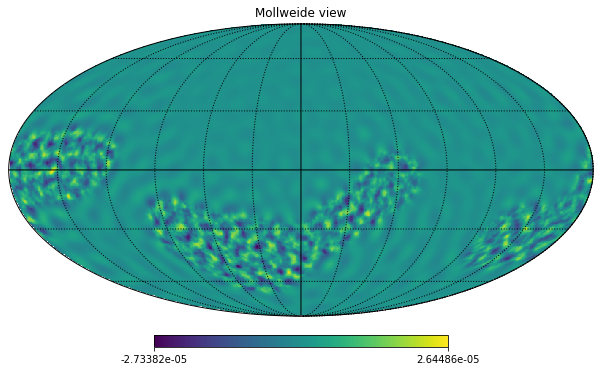

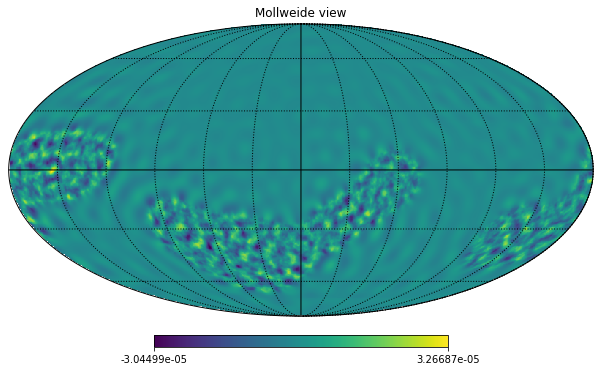

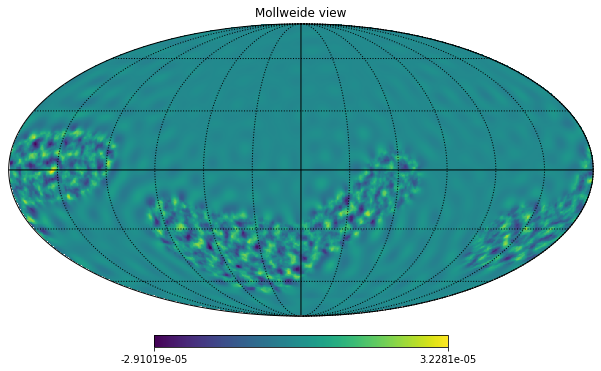

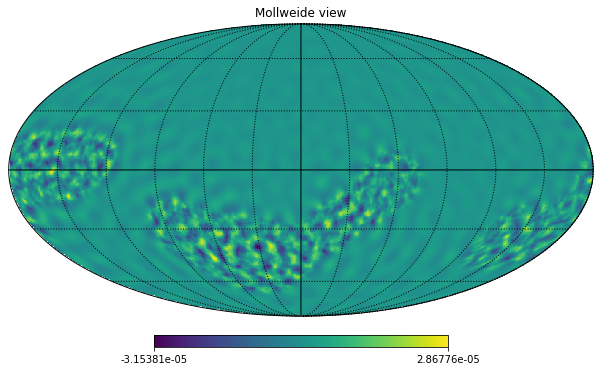

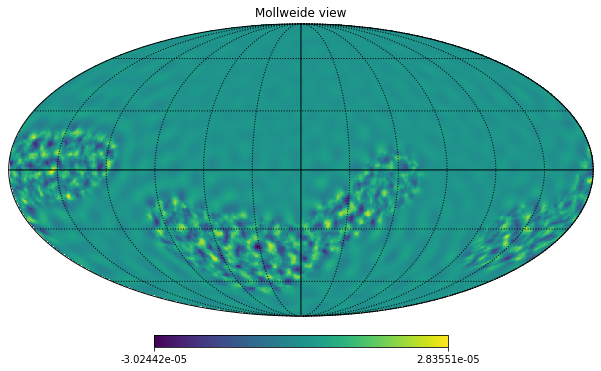

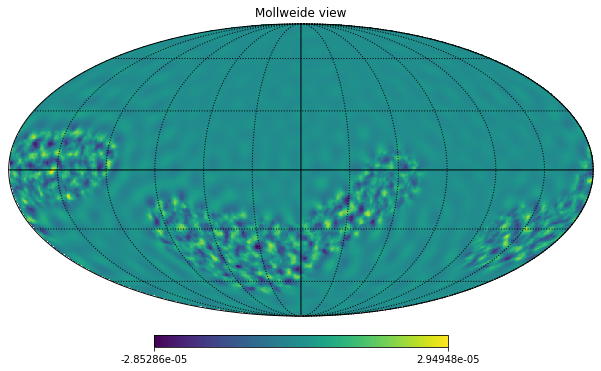

In [86]:
for p in pmaps_bp:
    hp.mollview(p)
    hp.graticule()

0.0 0.28284264067589 -180.0 180.0


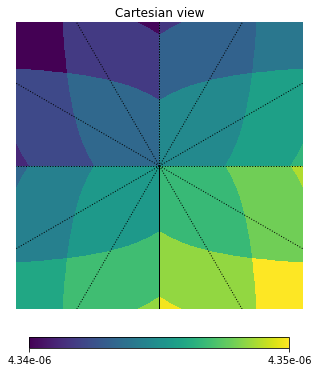

In [86]:
hp.cartview(pmap, lonra=[-0.1,0.1], latra=[-0.1,0.1], rot=[0,90,0] )
hp.graticule()

# Wflm

In [100]:
wflm = np.array([np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/p_p_sim0000/wflms/wflm_p_it%d.npy'%it) for it in range(10)])
# wflm2 = np.array([np.load('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/zb_terator_p_p_0000_nofg_OBD_solcond_3apr20/wflms/wflm_p_it%d.npy'%it) for it in range(1)])

(1e-07, 1.0)

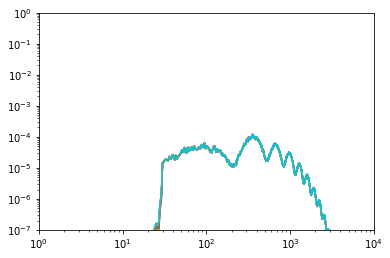

In [102]:
for n in range(10):
    plt.plot(hp.alm2cl(wflm[n]))
    # plt.plot(hp.alm2cl(wflm2[n]), ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,1e4)
plt.ylim(1e-7,1e0)

In [79]:
wmap = hp.alm2map(bandpass_alms(wflm[0],10,1000), nside=2048)

0.0 45.0 -180.0 180.0


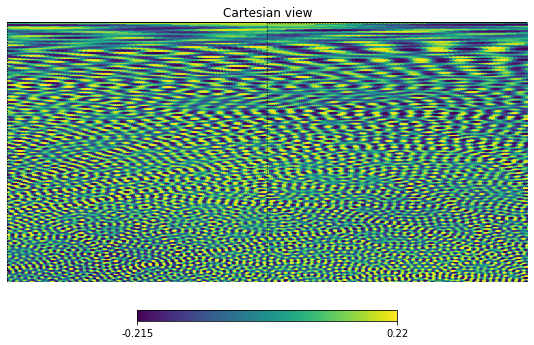

In [83]:
hp.cartview(wmap, lonra=[60,120], latra=[60,90], norm='hist', rot=[0,0,0])
hp.graticule()

# sim_p_p, x_p

In [ ]:
p_p = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_p_p_0000.fits')
x_p = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_test/qlms_dd/sim_x_p_0000.fits')

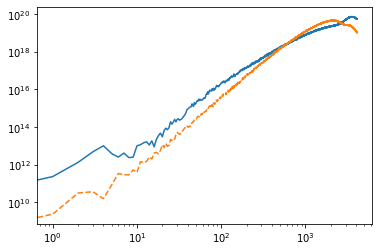

In [ ]:
for n in range(1):
    plt.plot(hp.alm2cl(p_p))
    plt.plot(hp.alm2cl(x_p), ls='--')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e0,1e3)
# plt.ylim(1e-7,1e0)

# Mask

In [202]:
import healpy as hp
m0 = hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_mask_r2.fits')
m1 = hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_mask_r5.fits')
m2 = hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_mask_r10.fits')
m3 = hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_mask_r50.fits')
m4 = hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_mask_r100.fits')

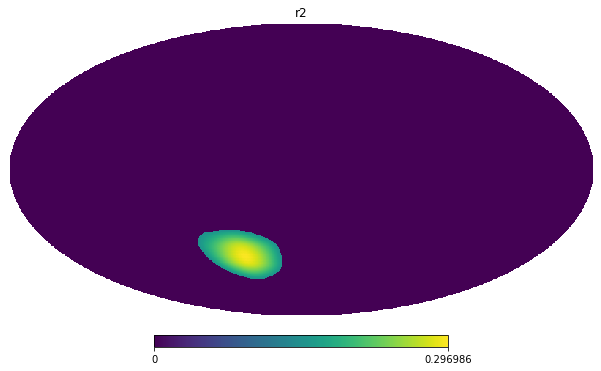

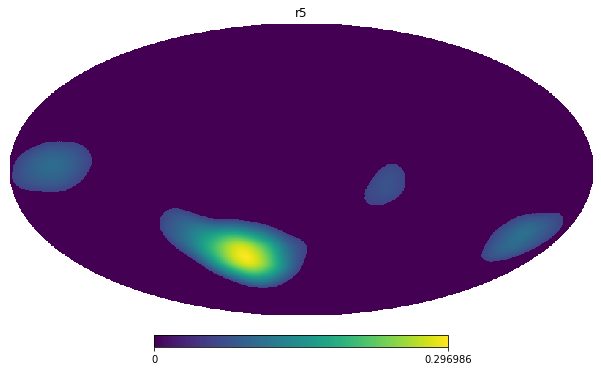

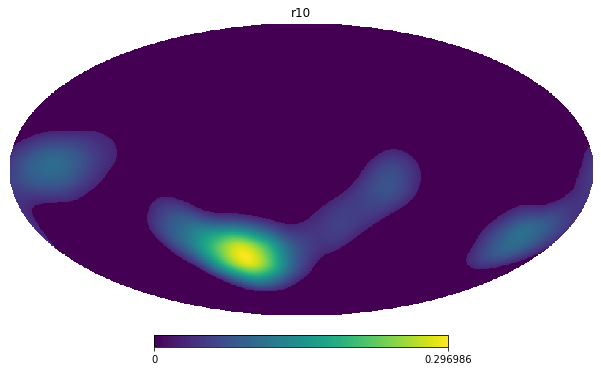

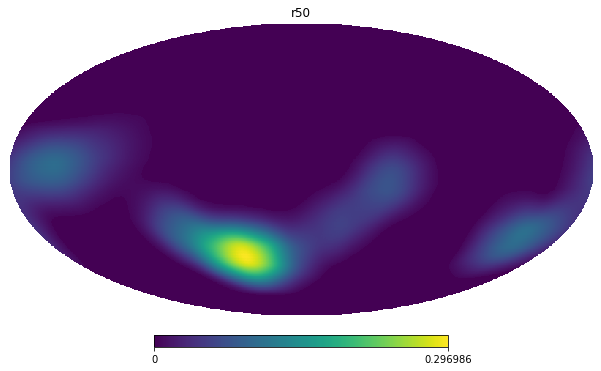

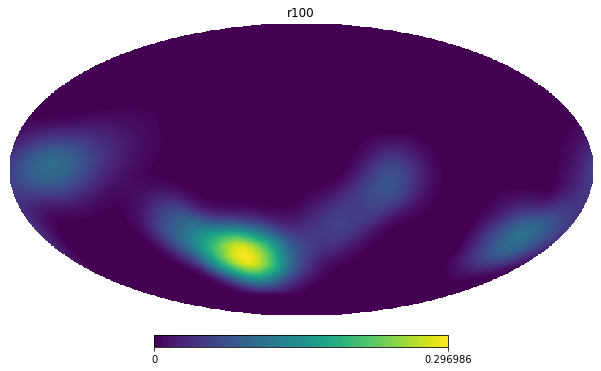

In [203]:
hp.mollview(m0, title='r2')
hp.mollview(m1, title='r5')
hp.mollview(m2, title='r10')
hp.mollview(m3, title='r50')
hp.mollview(m4, title='r100')

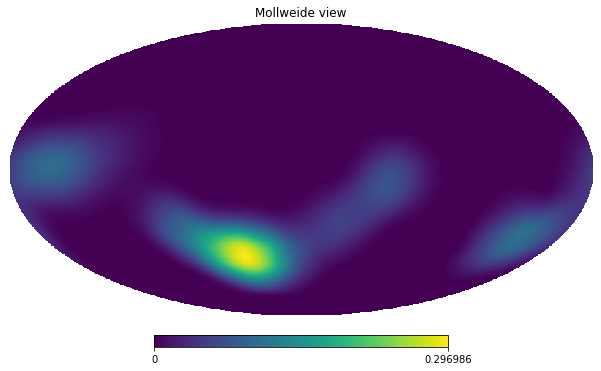

In [63]:
mask = hp.read_map('/global/homes/s/sebibel/git/lerepi/lerepi/data/dc08/masks/mask_r100.fits')
hp.mollview(mask)

# Derive transferfunction

In [13]:
beam = 2.3
lmax_transf = 2048
tf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf) * hp.pixwin(2048, lmax=lmax_transf)

In [30]:
def TEBlm_f(simidx):
    '''
    Returns fiducial ffp10 powerspectrum
    '''
    ffp10scalmTEB = 1e6 * hp.read_alm('/project/projectdirs/cmb/data/generic/cmb/ffp10/mc/scalar/ffp10_lensed_scl_cmb_000_alm_mc_%04d.fits'%simidx, hdu=(1,2,3))
    return ffp10scalmTEB

tebmap_f = np.array([hp.alm2map(TEBlm_f(simidx), nside=2048, pol=False) for simidx in simids]) # almTEB -> mapTEB

In [63]:
ClEE_f = ps.map2cl(tebmap_f[0,1], mask=mask, lmax=lmax, lmax_mask=lmax)
ClBB_f = ps.map2cl(tebmap_f[0,2], mask=mask, lmax=lmax, lmax_mask=lmax)

In [ ]:
Cl_fxD = ps.map2cl(tebmap_f[0,1]-, mask=mask, lmax=lmax, lmax_mask=lmax)

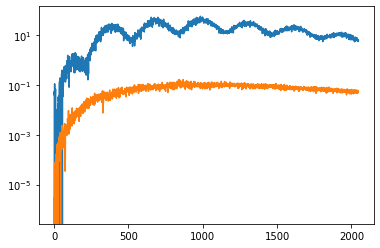

In [64]:
plt.plot(ClEE_f*scale_ps)
plt.plot(ClBB_f*scale_ps)
plt.yscale('log')

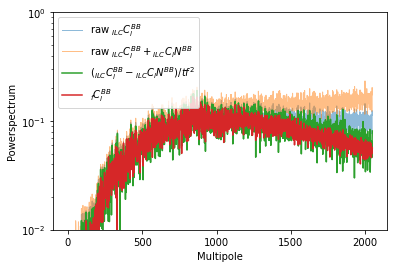

In [105]:
plt.plot(Cl[1]*scale_ps, label=r'raw $_{ILC}C_l^{BB}$', lw=1, alpha=0.5)
plt.plot((Cl[1]+ClN[1])*scale_ps, label=r'raw $_{ILC}C_l^{BB}+_{ILC}C_lN^{BB}$', lw=1, alpha=0.5)
# plt.plot(1/tf**2, label=r"$Tf^{2'3''}_p$")

plt.plot((Cl[1]-ClN[1])*scale_ps/tf[:2048]**2, label=r'$(_{ILC}C_l^{BB} -_{ILC}C_lN^{BB}) /tf^2$')
plt.plot(ClBB_f*scale_ps, label=r'$_fC_l^{BB}$')

plt.yscale('log')
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

plt.ylim((1e-2,1e0))
plt.legend()